In [155]:
# =====================================
# PART 1: IMPORT LIBRARIES
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

import joblib

In [156]:
# =====================================
# PART 2: LOAD DATA
# =====================================

df = pd.read_csv("./data/dynamic_record_gesture.csv")

print("\n===== DATA PREVIEW =====")
print(df.head())

print("\n===== DATA INFO =====")
print(df.info())

print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

print("\n===== BASIC STATISTICS =====")
print(df.describe())



===== DATA PREVIEW =====
    id gesture_name  timestamp    ax    ay    az    gx    gy    gz      p0  \
0  1.0            2   206434.0  0.92  0.74  0.91 -0.23 -2.38  2.28  3859.0   
1  1.0            2   206446.0  0.89  0.73  0.91 -2.03 -4.92  4.78  3867.0   
2  1.0            2   206458.0  0.95  0.74  0.91 -1.09 -5.62  3.35  3877.0   
3  1.0            2   206470.0  0.96  0.72  0.88 -1.13 -5.50  1.04  3873.0   
4  1.0            2   206482.0  0.94  0.72  0.90 -0.95 -4.49 -0.51  3861.0   

       p1      p2      p3  
0  3709.0  4095.0  4095.0  
1  3712.0  4095.0  4095.0  
2  3709.0  4095.0  4095.0  
3  3710.0  4095.0  4095.0  
4  3710.0  4095.0  4095.0  

===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9270 non-null   float64
 1   gesture_name  9270 non-null   object 
 2   timestamp     9270 non-null   


===== LABEL DISTRIBUTION =====
label
0.0    2529
4.0    1687
1.0    1686
2.0    1684
3.0    1684
Name: count, dtype: int64


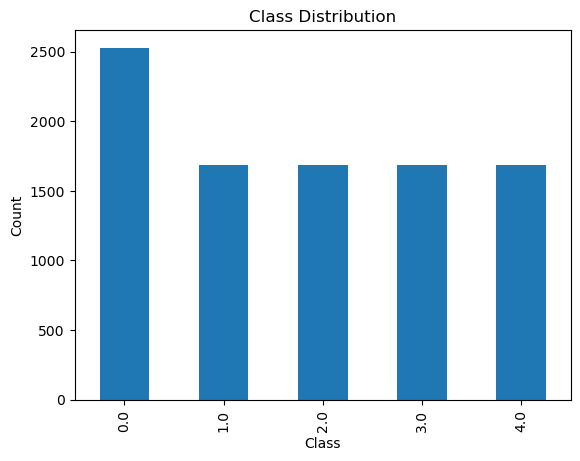

In [157]:
# =====================================
# PART 3: LABEL ENCODING
# =====================================

label_map = {
    "idle": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4
}

df["label"] = df["gesture_name"].map(label_map)

print("\n===== LABEL DISTRIBUTION =====")
print(df["label"].value_counts())

plt.figure()
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

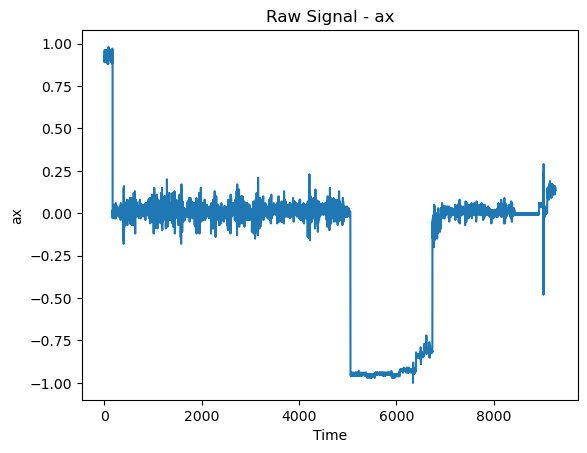

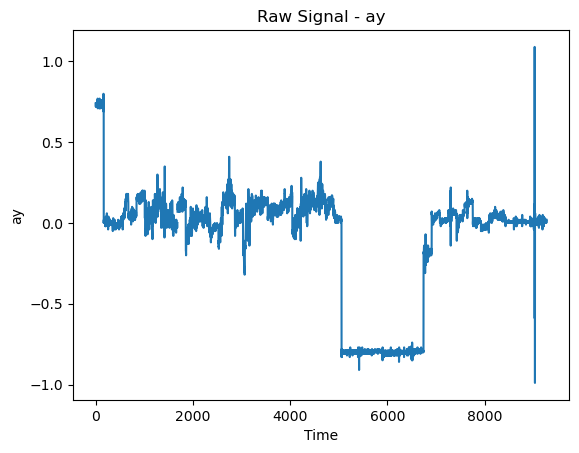

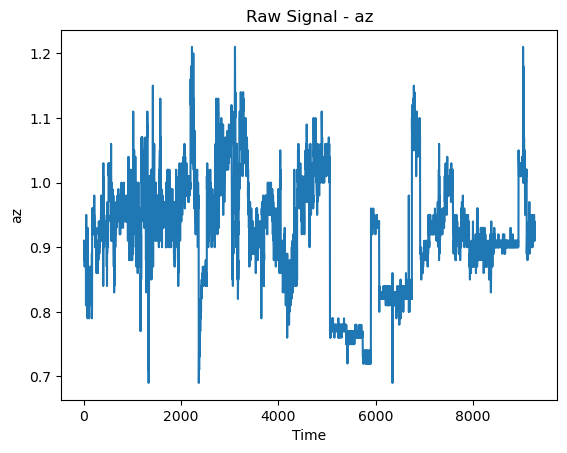

In [158]:
# =====================================
# PART 4: RAW SIGNAL VISUALIZATION
# =====================================

signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]

for col in signals[:3]:   # แสดง 3 ตัวแรก
    plt.figure()
    plt.plot(df[col].values)
    plt.title(f"Raw Signal - {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.show()


===== WINDOW DEBUG =====
Total windows: 364
Window shape: (50, 14)
Window label: 2.0


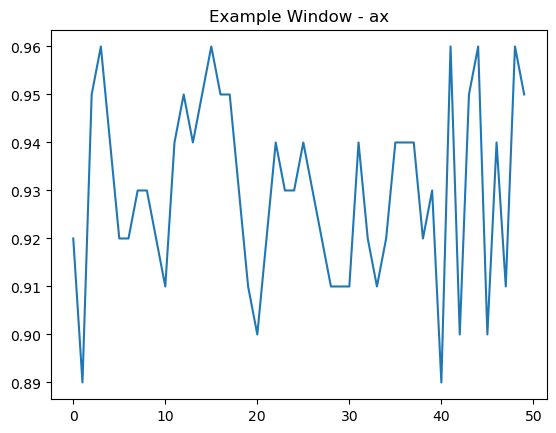

In [159]:
# =====================================
# PART 5: SLIDING WINDOW
# =====================================

WINDOW_SIZE = 50
STEP_SIZE = 25

def create_windows(df, window_size, step):
    windows = []
    labels = []

    for gesture_id in df["label"].unique():
        data = df[df["label"] == gesture_id]

        for start in range(0, len(data) - window_size, step):
            window = data.iloc[start:start+window_size]
            windows.append(window)
            labels.append(gesture_id)

    return windows, labels


windows, labels = create_windows(df, WINDOW_SIZE, STEP_SIZE)

print("\n===== WINDOW DEBUG =====")
print("Total windows:", len(windows))
print("Window shape:", windows[0].shape)
print("Window label:", labels[0])

plt.figure()
plt.plot(windows[0]["ax"].values)
plt.title("Example Window - ax")
plt.show()

In [160]:
# =====================================
# PART 6: FEATURE EXTRACTION
# =====================================

# -------------------------------------
# 1️⃣ Extract features function
# -------------------------------------

def extract_features(window):
    features = []
    signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]

    for col in signals:
        data = window[col].values

        features.append(np.mean(data))
        features.append(np.std(data))
        features.append(np.max(data))
        features.append(np.min(data))
        features.append(np.max(data) - np.min(data))  # range
        features.append(np.sqrt(np.mean(data**2)))    # RMS

    acc_mag = np.sqrt(window["ax"]**2 + window["ay"]**2 + window["az"]**2)
    gyro_mag = np.sqrt(window["gx"]**2 + window["gy"]**2 + window["gz"]**2)

    features.append(np.mean(acc_mag))
    features.append(np.mean(gyro_mag))

    return features


# -------------------------------------
# 2️⃣ Create Feature Names (62 features)
# -------------------------------------

signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]
stats = ["mean","std","max","min","range","rms"]

feature_names = []

for sig in signals:
    for stat in stats:
        feature_names.append(f"{stat}_{sig}")

feature_names.append("mean_acc_magnitude")
feature_names.append("mean_gyro_magnitude")

print("\n✓ Total feature names:", len(feature_names))


# -------------------------------------
# 3️⃣ Build Feature Matrix
# -------------------------------------

X = []
y = []

for window, label in zip(windows, labels):
    X.append(extract_features(window))
    y.append(label)

X = np.array(X)
y = np.array(y)

print("\n===== FEATURE MATRIX =====")
print("X shape:", X.shape)
print("y shape:", y.shape)

# ตรวจสอบ feature count ตรงไหม
assert X.shape[1] == len(feature_names), "❌ Feature mismatch!"
print("✓ Feature count matched (62)")


# -------------------------------------
# 4️⃣ Debug: ดูชื่อ feature + ค่า
# -------------------------------------

def explain_feature_vector(x, feature_names):
    print("\n===== FEATURE EXPLANATION =====\n")
    for i, (name, value) in enumerate(zip(feature_names, x)):
        print(f"{i:02d} | {name:25s} = {value:.6f}")

# แสดงตัวอย่าง window แรก
print("\nExample first 10 features:", X[0][:10])
explain_feature_vector(X[0], feature_names)


# -------------------------------------
# 5️⃣ Save feature names to file
# -------------------------------------

os.makedirs('./data/output_randomforest', exist_ok=True)

with open('./data/output_randomforest/selected_features.txt', 'w') as f:
    f.write("Selected Features:\n")
    f.write("="*50 + "\n\n")
    
    for i, feat in enumerate(feature_names, 1):
        f.write(f"{i}. {feat}\n")

print("\n✓ Saved: ./data/output_randomforest/selected_features.txt")


✓ Total feature names: 62

===== FEATURE MATRIX =====
X shape: (364, 62)
y shape: (364,)
✓ Feature count matched (62)

Example first 10 features: [0.9298     0.01891983 0.96       0.89       0.07       0.92999247
 0.7328     0.01114271 0.77       0.71      ]

===== FEATURE EXPLANATION =====

00 | mean_ax                   = 0.929800
01 | std_ax                    = 0.018920
02 | max_ax                    = 0.960000
03 | min_ax                    = 0.890000
04 | range_ax                  = 0.070000
05 | rms_ax                    = 0.929992
06 | mean_ay                   = 0.732800
07 | std_ay                    = 0.011143
08 | max_ay                    = 0.770000
09 | min_ay                    = 0.710000
10 | range_ay                  = 0.060000
11 | rms_ay                    = 0.732885
12 | mean_az                   = 0.889800
13 | std_az                    = 0.020444
14 | max_az                    = 0.950000
15 | min_az                    = 0.810000
16 | range_az                  = 0

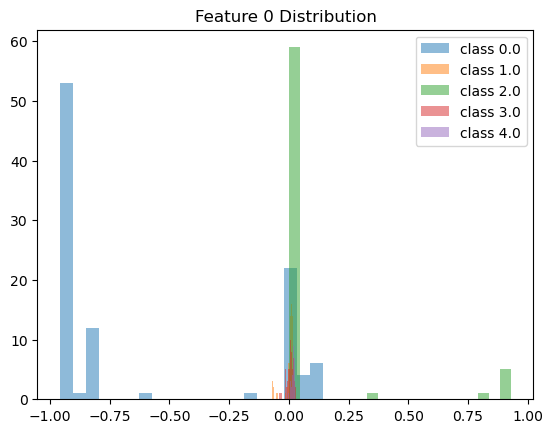

In [161]:
# =====================================
# PART 7: FEATURE DISTRIBUTION
# =====================================

plt.figure()
for label in np.unique(y):
    plt.hist(X[y==label, 0], bins=20, alpha=0.5, label=f"class {label}")

plt.legend()
plt.title("Feature 0 Distribution")
plt.show()

In [162]:
# =====================================
# PART 8: TRAIN TEST SPLIT
# =====================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (291, 62)
Test shape: (73, 62)


In [163]:
# =====================================
# PART 9: TRAIN MODEL
# =====================================

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 1.0
Test Accuracy: 0.9863013698630136



Accuracy: 0.9863013698630136

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.93      1.00      0.96        13
         2.0       1.00      1.00      1.00        13
         3.0       1.00      1.00      1.00        14
         4.0       1.00      1.00      1.00        13

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73



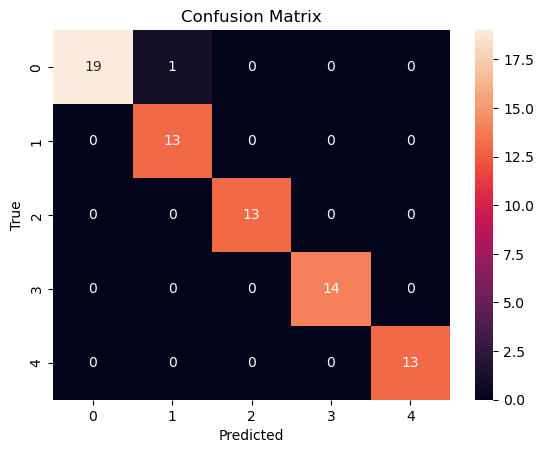

In [164]:
# =====================================
# PART 10: EVALUATION
# =====================================

y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

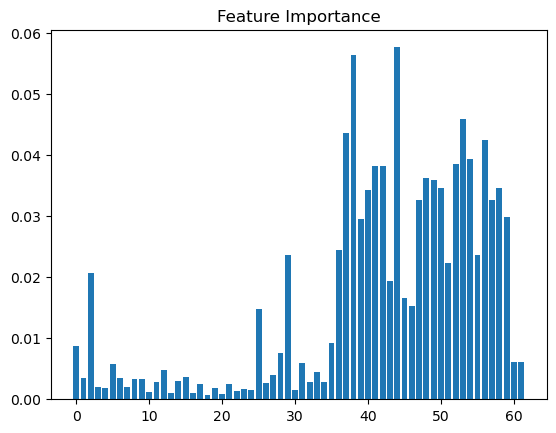


Top 10 Important Features:
Feature 44: 0.057710414237431125
Feature 38: 0.05638938048835254
Feature 53: 0.04592700335750597
Feature 37: 0.04359527297910274
Feature 56: 0.04243561654394306
Feature 54: 0.03944468622148282
Feature 52: 0.03860798217009257
Feature 41: 0.03829865717769536
Feature 42: 0.03819398245476834
Feature 48: 0.03627803219418898


In [165]:
# =====================================
# PART 11: FEATURE IMPORTANCE
# =====================================

importances = model.feature_importances_

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.show()

indices = np.argsort(importances)[::-1][:10]

print("\nTop 10 Important Features:")
for i in indices:
    print(f"Feature {i}: {importances[i]}")

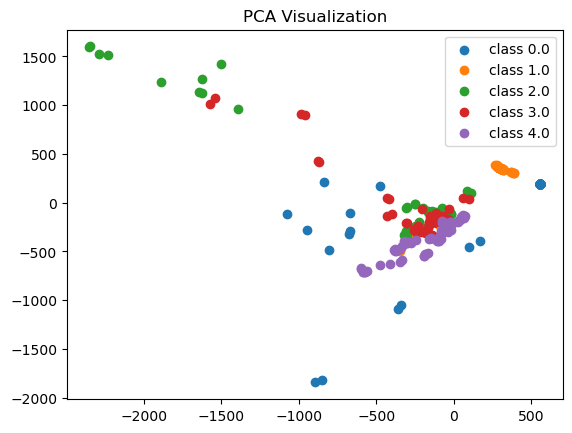

In [166]:
# =====================================
# PART 12: PCA VISUALIZATION
# =====================================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
for label in np.unique(y):
    plt.scatter(
        X_pca[y==label, 0],
        X_pca[y==label, 1],
        label=f"class {label}"
    )

plt.legend()
plt.title("PCA Visualization")
plt.show()

In [167]:
# =====================================
# PART 13: SAVE MODEL
# =====================================

joblib.dump(model, "./models/randomforest_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [168]:
print(X.shape)

(364, 62)
